# Setup and Preprocessing

## Load code and data

In [12]:
## import code
# basics and plotting
import re
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# data exploration
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression

# preprocessing
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight

# cross validation and modeling
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.dummy import DummyClassifier
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PoissonRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_predict

# tuning
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import validation_curve

# staticial comparison of model performance
# see https://github.com/janezd/baycomp
# to install library:
# pip install baycomp
from baycomp.single import two_on_single

# feature importance
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

# stats
import scipy.stats as stats

In [2]:
# load preprocessed data set into a dataframe
data = pd.read_csv('data_preproc.csv')

# XGBoost Comparison

Compare xgboost to logistic regression and poisson models

# Sexual Orientation in Sexual Minority Group

In [3]:
# drop features to reduce multicollinearity
data.drop(labels=['hopelessness', 'peer_vict', 'behav_act'], axis=1, inplace=True)

In [15]:
# define function to compute permutation feature importances
# perm_n: number of iterations of permutation feature importance procedure to aggregate
def perm_feat_imp(pipeline, perm_n=25, score='roc_auc'):
    
    # create dataframe to store results
    perm_results_df = pd.DataFrame(index=features.columns, columns=range(perm_n), dtype='float64')
    
    for i in range(perm_n):

        # split data for permutation importance computation
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

        # permutation importance computation
        pipeline.fit(X_train, y_train)
        perm_results = permutation_importance(pipeline, X_test, y_test, scoring=score, 
                                              n_repeats=10, random_state=0, n_jobs=2)

        # store results in a dataframe and sort
        perm_results_df.iloc[:, i] = perm_results.importances_mean
        
    # summarize results over iterations
    perm_results_summary = pd.DataFrame(index=features.columns)
    perm_results_summary['mean'] = perm_results_df.mean(axis=1)
    perm_results_summary['std'] = perm_results_df.std(axis=1)
    perm_results_summary.sort_values('mean', ascending=False, inplace=True)
    
    return perm_results_df, perm_results_summary

In [5]:
# define function to compute feature rank instability
# how much feature rank changes over aggregations of successively larger number of permutation importance iterations
def rank_instability(perm_results_df):
    instability = pd.Series(index=range(2,26), dtype='float')
    
    # compute feature rank instability between 1st iteration and the aggregation of the 1st 2 iterations
    agg1 = perm_results_df.iloc[:, 0].rank(ascending=False)
    agg2 = perm_results_df.iloc[:, 0:2].mean(axis=1).rank(ascending=False)
    instability[2] = abs(agg2 - agg1).mean()
    
    # compute feature rank instability between successive aggregations
    for i in range(3,26):
        agg1 = perm_results_df.iloc[:, 0:(i-1)].mean(axis=1).rank(ascending=False)
        agg2 = perm_results_df.iloc[:, 0:i].mean(axis=1).rank(ascending=False)
        instability[i] = abs(agg2 - agg1).mean()
        
    return instability

In [6]:
# create subset of data for orientation minority group
data_minor = data[data['orientation'] != 'Heterosexual/Straight'].copy()

## nssi_bin

In [7]:
# define target
target = data_minor['nssi_bin']

# define features
features = data_minor[['loneliness', 'depression', 'sex', 'gender',
                   'orientation', 'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = StratifiedKFold(n_splits=5)

In [8]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [9]:
# define algorithm
logreg = LogisticRegression(class_weight='balanced', random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, logreg)

In [10]:
# set C to 0.1
pipeline.set_params(logisticregression__C=0.1)

# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.670 +/- 0.010
The mean precision with cross-validation is: 0.841 +/- 0.007
The mean recall with cross-validation is: 0.675 +/- 0.019
The mean AUROC with cross-validation is: 0.725 +/- 0.015


                    mean       std
depression      0.044888  0.007870
child_adverse   0.018413  0.006234
sex             0.018151  0.007411
discrimination  0.017901  0.007003
gender          0.015972  0.007038
orientation     0.009629  0.006131
anxiety         0.007376  0.003622
hope            0.002254  0.002462
loneliness     -0.000260  0.001541


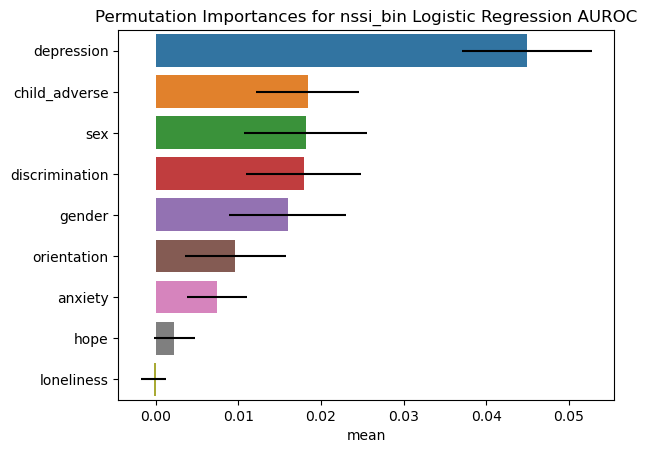

In [16]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for nssi_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

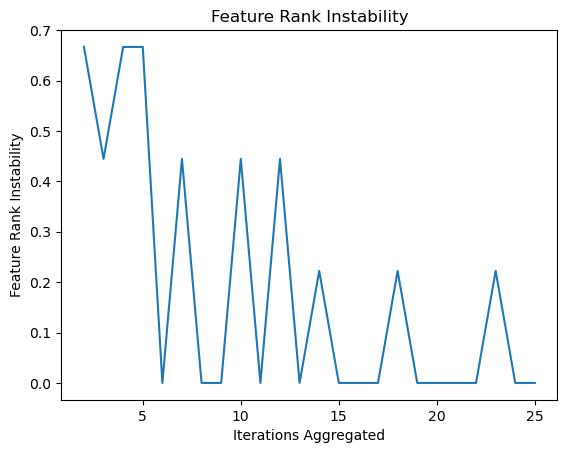

In [17]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

## si_bin

In [18]:
# define target
target = data_minor['si_bin']

In [19]:
# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.672 +/- 0.014
The mean precision with cross-validation is: 0.917 +/- 0.016
The mean recall with cross-validation is: 0.677 +/- 0.013
The mean AUROC with cross-validation is: 0.696 +/- 0.042


                    mean       std
depression      0.099171  0.019122
child_adverse   0.033462  0.009823
gender          0.004435  0.004978
anxiety         0.004215  0.003552
loneliness      0.003752  0.003198
orientation     0.001053  0.007492
sex             0.000105  0.003614
hope           -0.000210  0.002230
discrimination -0.001537  0.002577


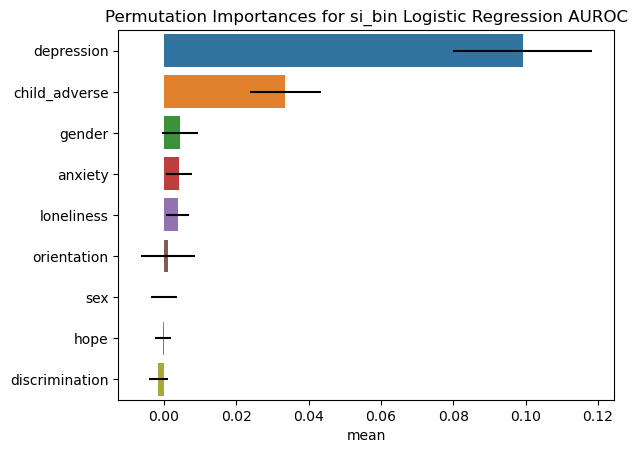

In [20]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for si_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

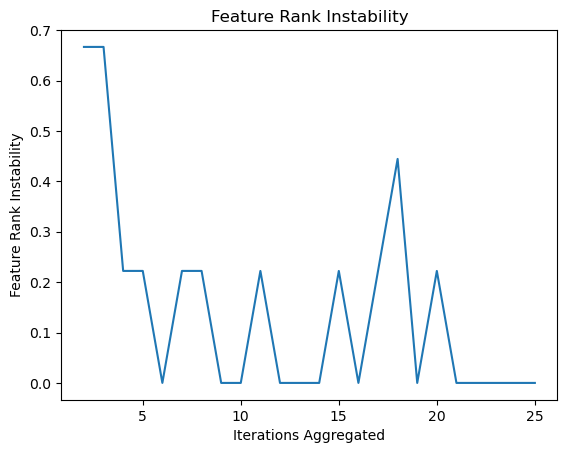

In [21]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

## attempt_bin

In [22]:
# define target
target = data_minor['attempt_bin']

In [23]:
# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.671 +/- 0.014
The mean precision with cross-validation is: 0.529 +/- 0.017
The mean recall with cross-validation is: 0.678 +/- 0.024
The mean AUROC with cross-validation is: 0.736 +/- 0.020


                    mean       std
depression      0.070335  0.010470
discrimination  0.048862  0.007374
child_adverse   0.034716  0.006592
orientation     0.004140  0.004718
hope            0.003834  0.002653
sex             0.002312  0.002315
gender          0.001945  0.003337
anxiety         0.000691  0.000920
loneliness     -0.000681  0.000910


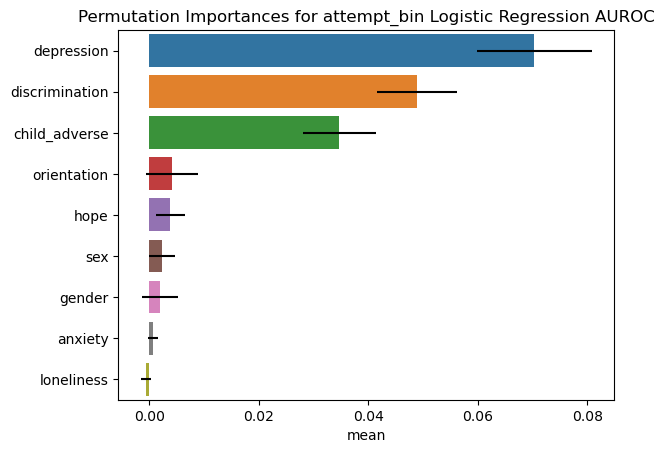

In [24]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for attempt_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

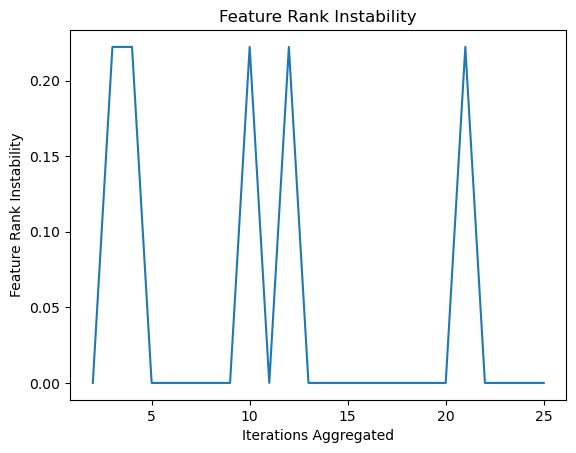

In [25]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

## nssi_year

In [26]:
# drop records missing nssi_year for nssi_year models
nssi_year_data = data.dropna(subset='nssi_year')

# create subset of data for orientation minority group
data_minor = nssi_year_data[nssi_year_data['orientation'] != 'Heterosexual/Straight'].copy()

In [27]:
# define target
target = data_minor['nssi_year']

# define features
features = data_minor[['loneliness', 'depression', 'sex', 'gender',
                   'orientation', 'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = KFold(n_splits=5)

In [28]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [29]:
# define algorithm
poisson = PoissonRegressor()

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, poisson)

In [30]:
pipeline.set_params(poissonregressor__alpha=5)

# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 98.397 +/- 25.974
The mean Poisson deviance with cross-validation is: 88.645 +/- 25.455


                     mean       std
depression      13.974197  4.376213
discrimination   3.404463  1.950457
anxiety          3.132912  1.651836
gender           1.952295  1.335290
sex              0.423458  0.802265
orientation      0.401391  0.930067
child_adverse    0.188129  0.776475
hope            -0.130607  0.613600
loneliness      -0.347781  0.658794


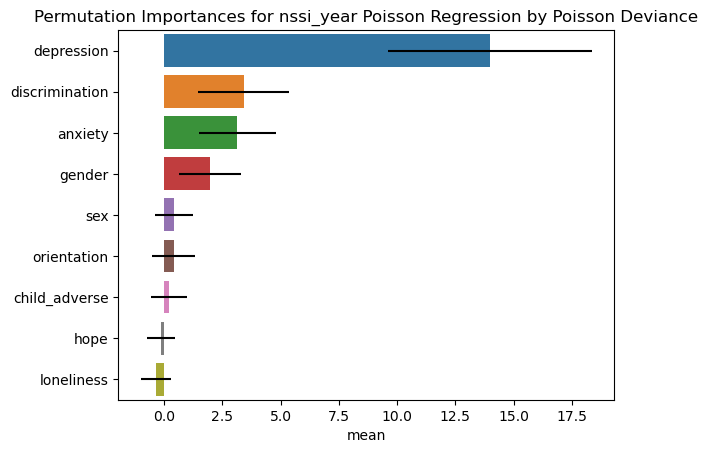

In [31]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline, score='neg_mean_poisson_deviance')

# view results
print(perm_results_summary)
plt.title("Permutation Importances for nssi_year Poisson Regression by Poisson Deviance")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

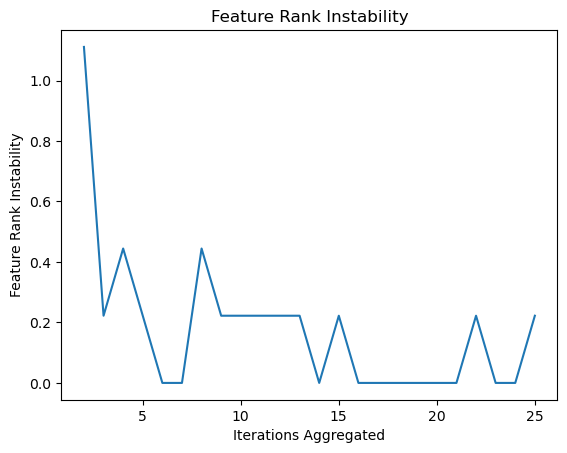

In [32]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

## si_year

In [33]:
# drop records missing si_year for si_year models
si_year_data = data.dropna(subset='si_year')

# create subset of data for orientation minority group
data_minor = si_year_data[si_year_data['orientation'] != 'Heterosexual/Straight'].copy()

In [34]:
# define target
target = data_minor['si_year']

# define features
features = data_minor[['loneliness', 'depression', 'sex', 'gender',
                   'orientation', 'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

In [35]:
# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 154.088 +/- 18.087
The mean Poisson deviance with cross-validation is: 148.545 +/- 19.731


                     mean       std
depression      26.322811  7.021553
anxiety          7.521658  3.567642
loneliness       1.932639  1.434441
child_adverse    1.205439  2.030887
discrimination   0.897449  1.644755
orientation      0.063935  1.462877
hope            -0.022458  0.920973
sex             -0.285938  0.413509
gender          -0.325330  0.573991


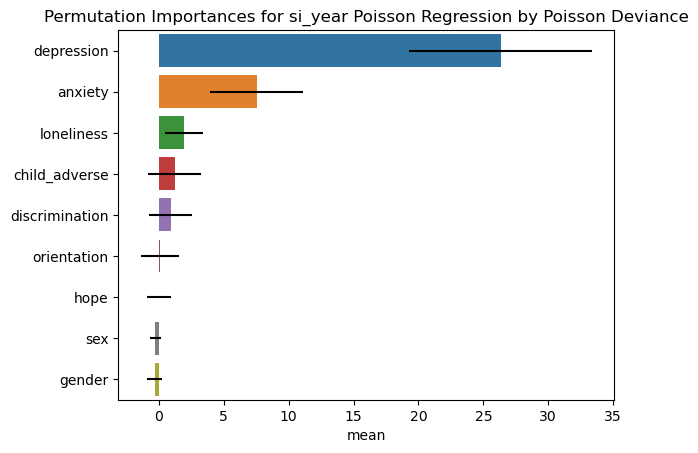

In [36]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline, score='neg_mean_poisson_deviance')

# view results
print(perm_results_summary)
plt.title("Permutation Importances for si_year Poisson Regression by Poisson Deviance")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

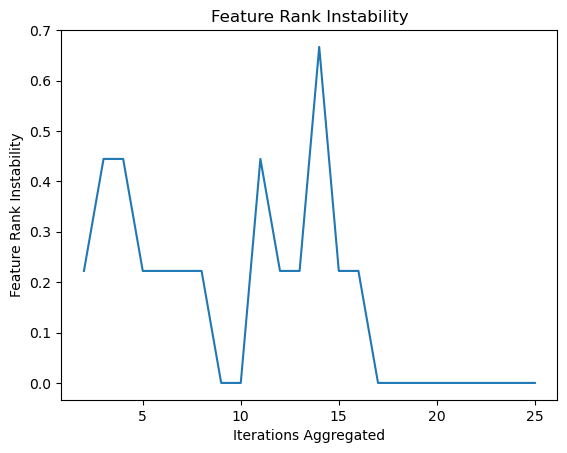

In [37]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

## Summary

The feature importance of orientation was only reliably greater than 0 for nssi_bin,  
and even in that case, its feature importance ranking was only 6th out of 9 features.